# New Lesson 3: Morphological Operations and Quantifications

You now know how to find objects of interest in an image and produce masks which correspond to these objects. Up until now, we've relied on good image preprocessing to produce quality masks. Now we will talk about morphological operations, which instead focus on making improvements to the masks directly.

1. In this module you will first learn
   What is a morphological operation
   How to choose the right parameters for your morphological operation
   Some common morphological operations
    - Erosion
    - Dilation
    - Opening
    - Closing


2. To quantify the change in nuclear localization and amount of your favorite protein with drug treatment. We would like to be able to answer two questions: 

    1) Does the *total* amount of protein per cell change with drug treatment and 
    2) How does the localization change between the nucleus and the cytoplasm? 
    
    Addressing these questions requires care when choosing the preprocessing algorithms to apply and their ordering, as well as batch processing across datasets.

3. Access properties of cells that have been detected, such as
    - Area
    - Intensity
    - Image vs mask properties
    - Measures of roundness
    - Aspect ratio
    - Convexity
    
   View the statistics of properties of detected cells;
   Filter out unwanted cells based on their properties

### 5.1 Load previously processed data (filter and thresholding)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage

sns.set_style('dark', rc={'image.cmap':'inferno'})

In [2]:
from skimage.io import imread

data_drug = imread("../data/confocal_drug_panel/drugA.tif")
data_nodrug = imread("../data/confocal_drug_panel/DMSO.tif")

In [3]:
import json
with open('../data/confocal_drug_panel/DMSO_metadata.json', mode='r') as f_nodrug:
    meta_nodrug = json.load(f_nodrug)

for key, value in meta_nodrug.items():
    print(key)

drug_slice = {}
nodrug_slice = {}
for idx, channel in enumerate(meta_nodrug['channels']):
    drug_slice[channel] = data_drug[3,:,:,idx]
    nodrug_slice[channel] = data_nodrug[3,:,:,idx] #add in the indexing when read in full dataset
    print(channel)


axes
pixel_size
cell_type
channels
raw_data_date
image_preprocessing_done
your_fav_protein
nucleus
actin


Text(0.5,0.98,'After Drug')

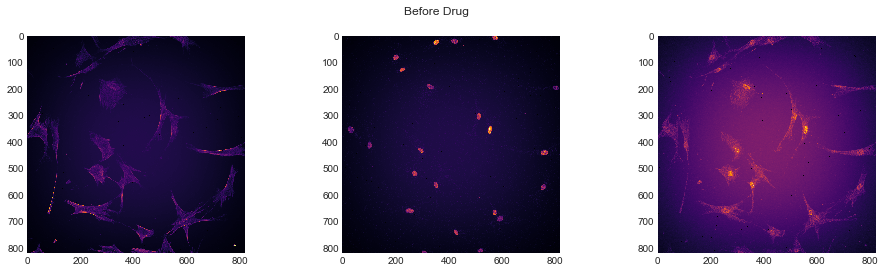

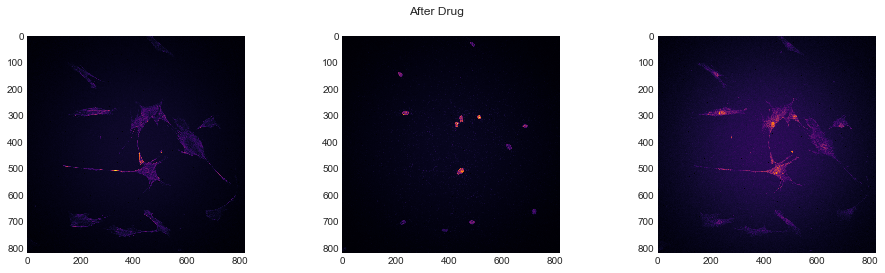

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].imshow(nodrug_slice["actin"])
ax[1].imshow(nodrug_slice['nucleus'])
ax[2].imshow(nodrug_slice["your_fav_protein"])
fig.suptitle('Before Drug')

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].imshow(drug_slice["actin"])
ax[1].imshow(drug_slice['nucleus'])
ax[2].imshow(drug_slice["your_fav_protein"])
fig.suptitle('After Drug')
    

In [5]:
from scipy.ndimage.filters import median_filter
from skimage import filters
import skimage.morphology as sm

channels_of_interest = ['actin', 'nucleus'] # Don't do anything to your_fav_protein!!
median_filter_size = 2
data = drug_slice
th_masked = {}
drug_erode = {}
drug_dilate = {}
drug_close = {}
drug_open = {}
drug_masks = {}

### 5.2 Morphorlogical Operations

In [6]:
for channel in channels_of_interest:
    original = data[channel].copy() # No need to start over-writing things...
    filtered = median_filter(original, size=median_filter_size)
    otsu_thresh = filters.threshold_otsu(filtered)
    th_masked[channel] = filtered > otsu_thresh

    morph1 = sm.binary_closing( th_masked[channel],sm.disk(3))
    morph2 = sm.binary_opening(morph1,sm.disk(3))
    
    drug_erode[channel] = sm.binary_erosion( th_masked[channel],sm.disk(3))
    drug_dilate[channel] = sm.binary_dilation( th_masked[channel],sm.disk(3))
    drug_close[channel] = sm.binary_closing( th_masked[channel],sm.disk(3))
    drug_open[channel] = sm.binary_opening( th_masked[channel],sm.disk(3))

    drug_masks[channel] = morph2
    

#### Four Seperate Operation Results

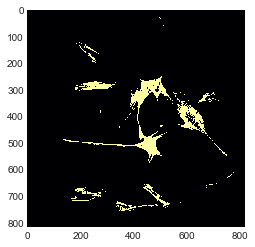

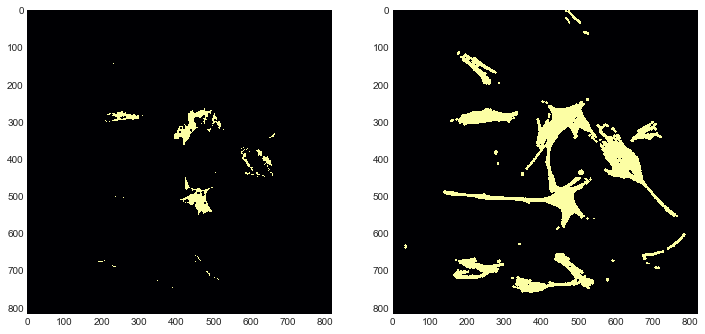

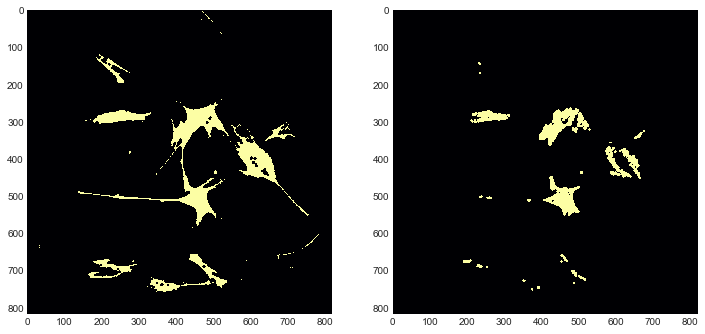

In [7]:
ch = 'actin'


fig, plt.imshow(th_masked[ch])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(drug_erode[ch])
ax[1].imshow(drug_dilate[ch])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(drug_close[ch])
ax[1].imshow(drug_open[ch])

#### Optimized Operation Results (Closing-opening)

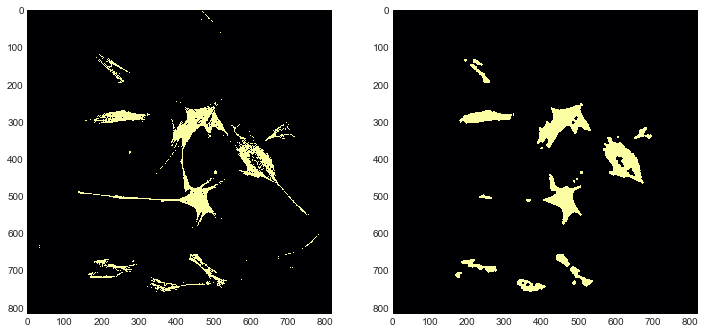

In [8]:
ch = 'actin'
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(th_masked[ch])
ax[1].imshow(drug_masks[ch])

### 5.3 Quantifications

#### Find cell body by getting rid of nuclei from the dialated actin mask 

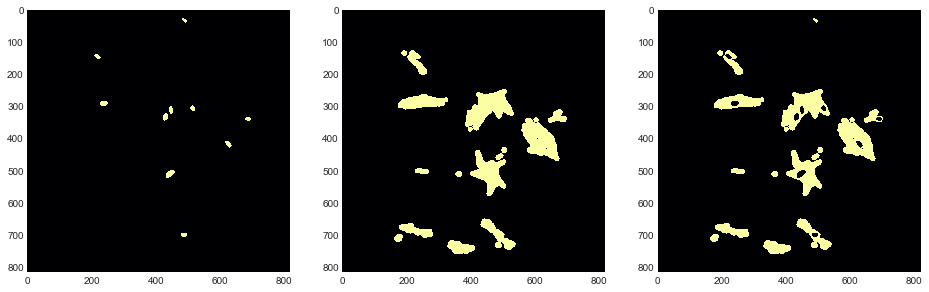

In [9]:
actin = drug_masks['actin'].copy()
nucleus = drug_masks['nucleus'].copy()
refined_actin_mask = sm.binary_dilation(actin, sm.disk(5))

refined_cell_body_mask= refined_actin_mask ^ nucleus
drug_masks['cell_body'] = drug_masks['actin'] ^ drug_masks['nucleus'] # ^ is essentially a minus sign

fig, ax = plt.subplots(1, 3, figsize=(16, 8))
ax[0].imshow(nucleus)
ax[1].imshow(refined_actin_mask)
ax[2].imshow(refined_cell_body_mask)

#### Calculate a mean nuclear and cytoplasmic intensities of *your_fav_protein*. For this, we'll apply our masks to the image of interest.

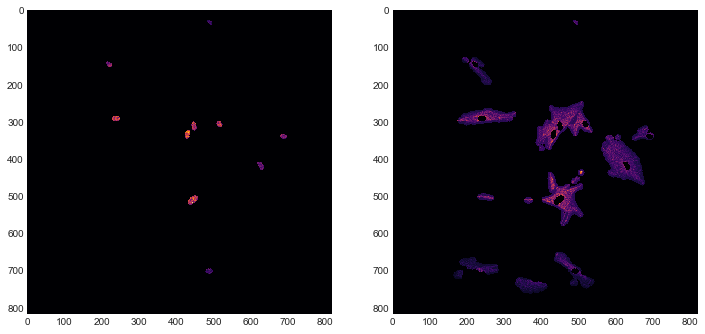

In [10]:
yfp = drug_slice['your_fav_protein']
inv_nucleus_mask = ~nucleus
inv_cell_body_mask = ~refined_cell_body_mask 

nuclear_intensities = yfp.copy()
nuclear_intensities[inv_nucleus_mask] = 0

cytoplasmic_intensities = yfp.copy()
cytoplasmic_intensities[inv_cell_body_mask] = 0

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(nuclear_intensities)
ax[1].imshow(cytoplasmic_intensities)

#### Final measure of nuclear and cytoplasmic averages

C:\Users\Andy\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Andy\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


The average nuclear intensity after drug treatment is: 9095.39 AU
The average cytoplasmic intensity after drug treatment is: 3996.55 AU.


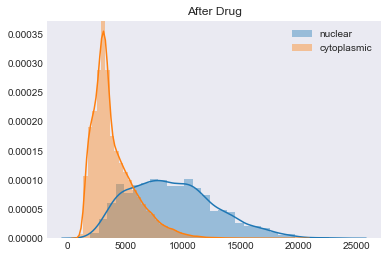

In [11]:
sns.distplot(nuclear_intensities[nuclear_intensities > 0].flatten(), kde=True, label='nuclear')
sns.distplot(cytoplasmic_intensities[cytoplasmic_intensities > 0].flatten(), kde=True, label='cytoplasmic')
plt.legend()
plt.title('After Drug')

print("The average nuclear intensity after drug treatment is: {0:.2f} AU".format(np.mean(nuclear_intensities[nuclear_intensities > 0])))
print("The average cytoplasmic intensity after drug treatment is: {0:.2f} AU.".format(np.mean(cytoplasmic_intensities[cytoplasmic_intensities > 0])))

### 5.4 Quantifying Properties of Identified Regions or Cells


In [12]:
from skimage.measure import label

#### Label Cells With Different Colors

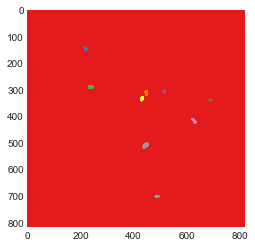

In [13]:
cell_labels = label(nucleus)
plt.imshow(cell_labels, cmap='Set1',vmin=0,vmax=cell_labels.max())

In [14]:
from skimage.measure import regionprops

In [15]:
props = regionprops(cell_labels, nuclear_intensities)

interactive(children=(Dropdown(description='label_index', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Ou…

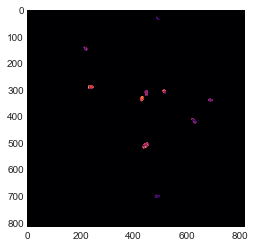

In [16]:
from ipywidgets import interactive

fig, plt.imshow(nuclear_intensities)

fig,
@interactive
def show_labeled_cells(label_index = list(range(cell_labels.max()))):
    current_cell_labels = cell_labels == props[label_index].label
    plt.imshow(current_cell_labels.astype(int), cmap='gray',vmin=0,vmax=1)
    plt.title("Nucleus #{:d}".format(label_index + 1))
show_labeled_cells

#### Single Cell Mask Properties

In [17]:
props[5].area


281

In [18]:
props[5].mean_intensity

13444.996441281139

In [19]:
props[5].centroid

(335.9217081850534, 430.56939501779357)

In [20]:
props[5].weighted_centroid

(335.5611713362788, 430.5548566930401)

#### Measures of Roundness


In [21]:
bounding_box = props[0].bbox
aspect_ratio = 1. * (bounding_box[3] - bounding_box[1]) / (bounding_box[2] - bounding_box[0])
print(aspect_ratio)

0.9375


In [22]:
props[5].solidity

0.972318339100346

In [23]:
def circleness(properties):
    bounding_box = properties.bbox
    aspect_ratio = 1. * (bounding_box[3] - bounding_box[1]) / (bounding_box[2] - bounding_box[0])
    
    # Aspect can be > 1. We want a value that provides a penalty when aspect is not near 1.
    if aspect_ratio > 1:
        aspect_penalty = 1./aspect_ratio
    else:
        aspect_penalty = aspect_ratio
        
    return properties.solidity * aspect_penalty

circleness(props[5])

0.6763953663306755